## Conclusion

Le classifieur Random Forest avec TF-IDF performe bien pour distinguer les articles Fake et Real.  

- La haute précision indique que le texte contient des informations fiables pour cette tâche.  
- Des améliorations futures pourraient inclure des modèles deep learning ou des features supplémentaires (source, auteur, date).

In [17]:
print("Conclusion:")
print("The Random Forest model with TF-IDF achieved high accuracy in detecting fake news.")
print("The model shows strong precision and recall for both fake and real news classes.")

Conclusion:
The Random Forest model with TF-IDF achieved high accuracy in detecting fake news.
The model shows strong precision and recall for both fake and real news classes.


## Matrice de confusion

La matrice de confusion montre visuellement les vrais et faux positifs et négatifs.

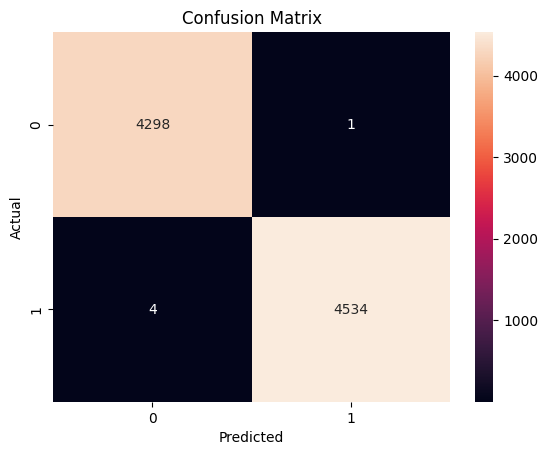

In [16]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Évaluation du modèle

Nous évaluons le modèle sur l’ensemble de test avec les métriques suivantes :  
- Accuracy (Précision globale)  
- Précision / Rappel / F1-score  
- Matrice de confusion

Accuracy: 0.9994341971257213
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4299
           1       1.00      1.00      1.00      4538

    accuracy                           1.00      8837
   macro avg       1.00      1.00      1.00      8837
weighted avg       1.00      1.00      1.00      8837



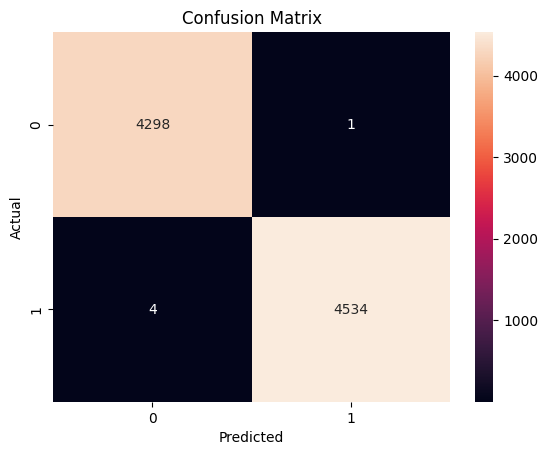

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Séparer X et y
X = df["processed_text"].dropna()  # SUPPRIME les NaN
y = df.loc[X.index, "label"]       # garde les labels correspondants

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorisation et prédiction
X_test_vec = vectorizer.transform(X_test)
y_pred = model.predict(X_test_vec)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Prédiction d'exemples

Nous testons le modèle sur quelques exemples de textes pour vérifier son comportement sur de nouvelles données.

In [13]:
def predict_news(text):
    text_vec = vectorizer.transform([text])
    pred = model.predict(text_vec)[0]
    return "Fake News" if pred == 1 else "Real News"

# Test
print(predict_news("The president announced a new policy today."))
print(predict_news("Aliens landed in Tunisia yesterday according to secret sources."))

Fake News
Fake News


## Chargement du modèle

Nous chargeons le modèle Random Forest pré-entraîné ainsi que le vectorizer TF-IDF utilisé lors de l’entraînement.

In [12]:
import joblib

model = joblib.load("../models/rf_model.pkl")
vectorizer = joblib.load("../models/tfidf_vectorizer.pkl")

print("Model and vectorizer loaded successfully!")

Model and vectorizer loaded successfully!


## Top mots fréquents

Nous listons les mots les plus fréquents dans tout le dataset.  
Cela peut aider à identifier les mots-clés qui caractérisent les articles Fake et Real.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", max_features=20)
X = vectorizer.fit_transform(df["text"])

words = vectorizer.get_feature_names_out()
freq = X.toarray().sum(axis=0)

word_freq = dict(zip(words, freq))
print(word_freq)

{'clinton': np.int64(28695), 'donald': np.int64(28127), 'government': np.int64(28048), 'house': np.int64(27753), 'just': np.int64(24967), 'like': np.int64(22774), 'new': np.int64(31311), 'obama': np.int64(28203), 'people': np.int64(41857), 'president': np.int64(55892), 'republican': np.int64(25568), 'reuters': np.int64(29425), 'said': np.int64(132825), 'state': np.int64(34488), 'states': np.int64(26843), 'told': np.int64(23367), 'trump': np.int64(134000), 'united': np.int64(23601), 'white': np.int64(22745), 'year': np.int64(24998)}


## WordCloud Real News

Nous générons un WordCloud pour les articles Real.  
Cela permet de comparer visuellement avec les Fake News et voir les différences de vocabulaire.

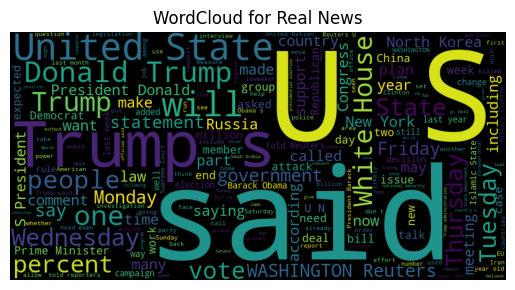

In [10]:
real_text = " ".join(df[df["label"] == 0]["text"])

wc = WordCloud(width=800, height=400).generate(real_text)

plt.imshow(wc)
plt.axis("off")
plt.title("WordCloud for Real News")
plt.show()

## WordCloud Fake News

Nous générons un WordCloud pour les articles Fake.  
Cela permet de visualiser les mots les plus fréquents et spécifiques à cette classe.

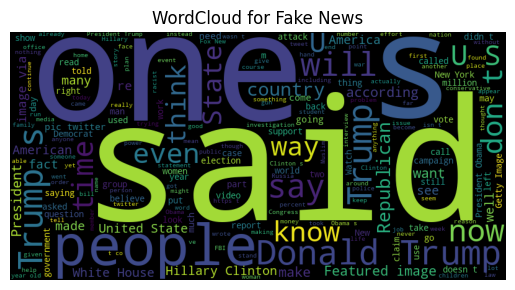

In [9]:
fake_text = " ".join(df[df["label"] == 1]["text"])

wc = WordCloud(width=800, height=400).generate(fake_text)

plt.imshow(wc)
plt.axis("off")
plt.title("WordCloud for Fake News")
plt.show()

## Analyse de la longueur des textes

Nous analysons la distribution de la longueur des articles dans le dataset.  
- Les articles très courts ou très longs peuvent indiquer du bruit ou des anomalies.  
- Ces informations peuvent guider les décisions de prétraitement.

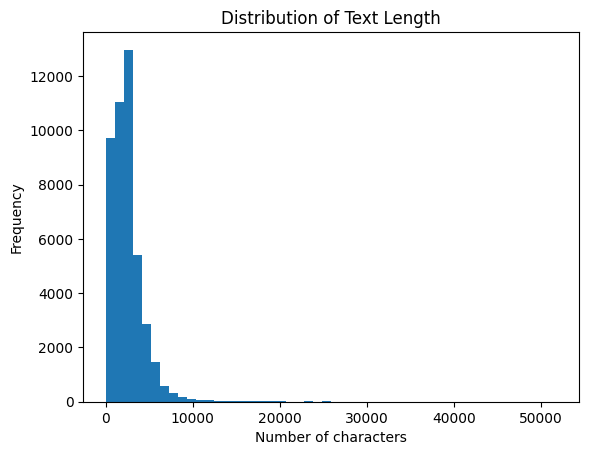

In [8]:
df["text_length"] = df["text"].apply(len)

plt.hist(df["text_length"], bins=50)
plt.title("Distribution of Text Length")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.show()

## Répartition des classes

Nous visualisons le nombre d'articles Fake vs Real afin de vérifier tout déséquilibre dans le dataset.  
Cela permet de savoir si le modèle pourrait être biaisé vers une classe.

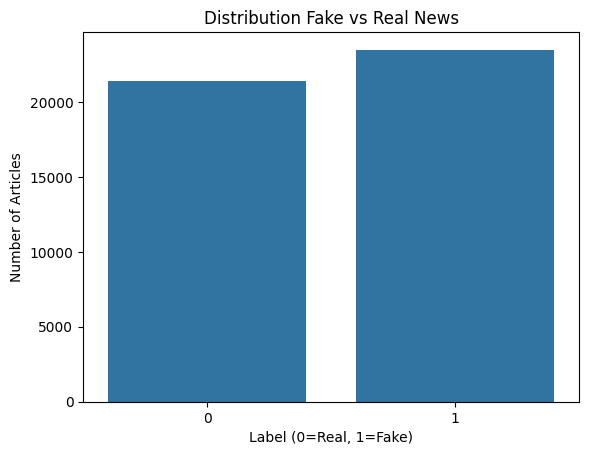

In [7]:
import seaborn as sns

sns.countplot(x="label", data=df)
plt.title("Distribution Fake vs Real News")
plt.xlabel("Label (0=Real, 1=Fake)")
plt.ylabel("Number of Articles")
plt.show()

In [6]:
df.describe()

,label
count,44898.000000
mean,0.522985
std,0.499477
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


## Statistiques générales

On regarde les statistiques descriptives pour comprendre la longueur des textes, les valeurs manquantes et les distributions numériques du dataset.

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   text            44898 non-null  str  
 1   label           44898 non-null  int64
 2   clean_text      44816 non-null  str  
 3   processed_text  44182 non-null  str  
dtypes: int64(1), str(3)
memory usage: 282.6 MB


## Présentation du Dataset 

Le dataset contient des articles de news étiquetés comme 'Fake News' (1) ou 'Real News' (0).  
Chaque ligne contient le texte brut de l'article et son label.

Nous commençons par explorer le nombre d'articles, vérifier les valeurs manquantes et comprendre les caractéristiques générales du dataset.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df = pd.read_csv("../data/processed/fake_news_processed.csv")
df.head()

,text,label,clean_text,processed_text
0,The Trump administration has been getting abso...,1,the trump administration has been getting abso...,trump administration getting absolutely pummel...
1,NAIROBI (Reuters) - Kenyan police shot dead tw...,0,nairobi reuters kenyan police shot dead two p...,nairobi reuters kenyan police shot dead two pe...
2,PC is killing our country. This is called figh...,1,pc is killing our country this is called fight...,pc killing country called fighting back counte...
3,WASHINGTON (Reuters) - Republicans are poised ...,0,washington reuters republicans are poised to ...,washington reuters republican poised repeal u ...
4,(Reuters) - A U.S. appeals court ruled on Frid...,0,reuters a us appeals court ruled on friday th...,reuters u appeal court ruled friday arkansas l...


## Projet Détection de Fake News 

Ce notebook présente l'analyse exploratoire des données (EDA) et les étapes de machine learning pour détecter les articles de fake news.  
Nous analyserons le dataset, visualiserons les tendances et évaluerons un classifieur Random Forest entraîné avec des features TF-IDF.